In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import sys
ROOT = Path.cwd().parent
DATA = ROOT / "data"
sys.path.append(str(ROOT / "functions"))

from categoric_functions import *
from numeric_functions import *

print("Libraries imported!")

Libraries imported!


## 1. Load Training Data (for fitting encoders) and Kaggle Test Data

In [2]:
# Load FULL training data (not the split version)
train_path = DATA / "train_merged.csv"
train_df = pd.read_csv(train_path, low_memory=False)
print(f"Train shape: {train_df.shape}")

# Load Kaggle test data
test_path = DATA / "test_merged.csv"
kaggle_test = pd.read_csv(test_path, low_memory=False)
print(f"Kaggle Test shape: {kaggle_test.shape}")

# Save TransactionID for submission
submission_ids = kaggle_test['TransactionID'].copy()

Train shape: (590540, 434)
Kaggle Test shape: (506691, 433)


In [3]:
# Reduce memory
train_df = reduce_mem_usage(train_df)
kaggle_test = reduce_mem_usage(kaggle_test)

Memory usage decreased to 645.97 Mb (67.0% reduction)
Memory usage decreased to 561.50 Mb (66.5% reduction)


## 2. Apply Same Preprocessing Pipeline as EDA.ipynb

In [4]:
# =============================================================================
# Step 1: Drop high missing columns (>95%)
# =============================================================================
threshold = 95
high_missing = top_missing_cols(train_df, thresh=threshold)
cols_to_drop = high_missing[high_missing['missing_percent'] > threshold]['col'].tolist()

train_df = train_df.drop(columns=cols_to_drop)
kaggle_test = kaggle_test.drop(columns=[c for c in cols_to_drop if c in kaggle_test.columns])

print(f"Dropped {len(cols_to_drop)} high-missing columns")
print(f"Train: {train_df.shape}, Test: {kaggle_test.shape}")

There are 414 columns with missing values.
There are 9 columns with missing percent > 95%
Dropped 9 high-missing columns
Train: (590540, 425), Test: (506691, 433)


In [5]:
# =============================================================================
# Step 2: Categorical Engineering Pipeline
# =============================================================================
def apply_categorical_engineering(df, rare_maps=None):
    df = df.copy()
    df, rare_maps = encode_rare_categories(
        df, 
        columns={'card3': 200, 'card5': 300},
        rare_maps=rare_maps
    )
    df = (df
        .pipe(clean_email_domains)
        .pipe(create_email_match)
        .pipe(consolidate_device_info)
        .pipe(extract_screen_features)
    )
    return df, rare_maps

# Apply - learn from train, apply to test
train_df, rare_maps = apply_categorical_engineering(train_df, rare_maps=None)
kaggle_test, _ = apply_categorical_engineering(kaggle_test, rare_maps=rare_maps)

print("Categorical engineering complete!")

Categorical engineering complete!


In [6]:
# =============================================================================
# Step 3: Interaction Features (use same pairs as EDA)
# =============================================================================
categorical_to_scan = [
    'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 'OS_type', 'Device_name',
    'card5', 'card3', 'card6', 'card4', 'ProductCD', 'DeviceType', 
    'screen_width', 'screen_height', 'total_pixels', 'aspect_ratio',
    'id_28', 'id_20', 'id_15', 'id_19'
]

# Scan on train to identify interactions
top_combos = scan_all_bivariate_combinations(
    train_df, 
    feature_list=[c for c in categorical_to_scan if c in train_df.columns],
    target='isFraud',
    min_samples=50,
    top_n=20
)

interactions = [(row['feature1'], row['feature2']) for _, row in top_combos.iterrows()]

train_df = create_interaction_features(train_df, interactions)
kaggle_test = create_interaction_features(kaggle_test, interactions)

print(f"Created {len(interactions)} interaction features")

Scanning 171 feature pairs...
Progress: 100/171 pairs processed...

Analysis complete! Found 171 valid combinations.
Top fraud rate: 97.6%
Created 20 interaction features


In [7]:
# =============================================================================
# Step 4: Drop transformed columns
# =============================================================================
drop_cols = ['P_emaildomain', 'R_emaildomain', 'id_30', 'DeviceInfo', 'id_33']
train_df = train_df.drop(columns=drop_cols, errors='ignore')
kaggle_test = kaggle_test.drop(columns=drop_cols, errors='ignore')

print("Dropped original transformed columns")

Dropped original transformed columns


In [8]:
# =============================================================================
# Step 5: Encoding
# =============================================================================
# Define categorical features
categorical_features = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'DeviceType', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 
    'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 
    'id_27', 'id_28', 'id_29', 'id_31', 'id_32', 'id_34', 'id_35', 'id_36', 
    'id_37', 'id_38', 'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match',
    'OS_type', 'Device_name'
]

# Add interaction features
interaction_cols = [c for c in train_df.columns if c.startswith('inter_')]
categorical_features.extend(interaction_cols)

# Get object columns that are categorical
object_columns = [col for col in train_df.select_dtypes(include=['object']).columns 
                  if col in categorical_features]

cardinality_threshold = 15
low_card = [col for col in object_columns if train_df[col].nunique() <= cardinality_threshold]
high_card = [col for col in object_columns if train_df[col].nunique() > cardinality_threshold]

# Frequency encoding for high cardinality
train_df, freq_maps = apply_frequency_encoding(train_df, high_card, normalize=True)
kaggle_test, _ = apply_frequency_encoding(kaggle_test, high_card, freq_dict=freq_maps)

# Label encoding for low cardinality
train_df, label_encoders = apply_label_encoding(train_df, low_card)
kaggle_test, _ = apply_label_encoding(kaggle_test, low_card, encoder_dict=label_encoders)

print(f"Encoded {len(high_card)} high-card and {len(low_card)} low-card features")

Encoded 22 high-card and 29 low-card features


In [9]:
# =============================================================================
# Step 6: V-column reduction
# =============================================================================
v_cols = [col for col in train_df.columns if col.startswith('V')]

v_pattern_groups = group_by_missing_pattern(train_df, v_cols)
representative_v = []

for pattern_id, info in v_pattern_groups.items():
    group_cols = info['columns']
    if len(group_cols) == 1:
        representative_v.extend(group_cols)
        continue
    ks_res = test_feature_discrimination(train_df, group_cols, test='ks')
    if not ks_res.empty:
        representative_v.append(ks_res.iloc[0]['Feature'])

# Filter V columns
cols_to_keep = train_df.columns.difference(v_cols).union(pd.Index(representative_v))
train_df = train_df[cols_to_keep]
kaggle_test = kaggle_test[[c for c in cols_to_keep if c in kaggle_test.columns]]

print(f"V columns reduced: {len(v_cols)} -> {len(representative_v)}")

V columns reduced: 339 -> 15


In [10]:
# =============================================================================
# Step 7: Numerical Feature Engineering
# =============================================================================
# Time features
train_df = convert_dt_to_day(train_df)
kaggle_test = convert_dt_to_day(kaggle_test)

# UID creation
train_df = create_uid(train_df, uid_cols=['card1', 'addr1', 'D1'])
kaggle_test = create_uid(kaggle_test, uid_cols=['card1', 'addr1', 'D1'])

# Normalize D columns
train_df = normalize_d_columns(train_df)
kaggle_test = normalize_d_columns(kaggle_test)

# Amount features
train_df = extract_amt_decimal(train_df)
kaggle_test = extract_amt_decimal(kaggle_test)

# Log transform
train_df['TransactionAmt_log'] = np.log1p(train_df['TransactionAmt'])
kaggle_test['TransactionAmt_log'] = np.log1p(kaggle_test['TransactionAmt'])

# C velocity features
train_df = create_c_velocity_features(train_df)
kaggle_test = create_c_velocity_features(kaggle_test)

# UID aggregations
train_df, uid_agg_maps = create_uid_aggregations(train_df, uid_col='uid')
kaggle_test, _ = create_uid_aggregations(kaggle_test, uid_col='uid', agg_maps=uid_agg_maps)

print("Numerical engineering complete!")
print(f"Train: {train_df.shape}, Test: {kaggle_test.shape}")

Numerical engineering complete!
Train: (590540, 161), Test: (506691, 109)


In [11]:
# =============================================================================
# Step 8: Load filtered_features from saved pickle
# =============================================================================
with open(DATA / "feature_lists.pkl", 'rb') as f:
    feature_lists = pickle.load(f)

filtered_features = feature_lists['filtered_features']
print(f"Using {len(filtered_features)} filtered features")

# Check which features are available in both datasets
available_features = [f for f in filtered_features if f in train_df.columns and f in kaggle_test.columns]
missing_in_test = [f for f in filtered_features if f not in kaggle_test.columns]

if missing_in_test:
    print(f"\n⚠️ Features missing in test: {missing_in_test}")
    print(f"Using {len(available_features)} available features")
else:
    print(f"\n✅ All {len(filtered_features)} features available!")

Using 51 filtered features

⚠️ Features missing in test: ['V222', 'V11', 'id_01', 'screen_height', 'total_pixels', 'aspect_ratio', 'id_06']
Using 44 available features


## 3. Train LightGBM on Full Training Data

In [12]:
from lightgbm import LGBMClassifier

# Prepare data
X_train = train_df[available_features].copy()
y_train = train_df['isFraud'].copy()
X_kaggle_test = kaggle_test[available_features].copy()

# Handle missing values
MISSING_FLAG = -999
X_train = X_train.fillna(MISSING_FLAG)
X_kaggle_test = X_kaggle_test.fillna(MISSING_FLAG)

print(f"X_train: {X_train.shape}")
print(f"X_kaggle_test: {X_kaggle_test.shape}")
print(f"Training fraud rate: {y_train.mean()*100:.2f}%")

X_train: (590540, 44)
X_kaggle_test: (506691, 44)
Training fraud rate: 3.50%


In [13]:
# Train LightGBM
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

lgb_model = LGBMClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training LightGBM on full training data...")
lgb_model.fit(X_train, y_train)
print("✅ Training complete!")

Training LightGBM on full training data...
✅ Training complete!


## 4. Generate Predictions and Create Submission File

In [14]:
# Predict probabilities
predictions = lgb_model.predict_proba(X_kaggle_test)[:, 1]

print(f"Predictions shape: {predictions.shape}")
print(f"Prediction stats:")
print(f"  Min: {predictions.min():.4f}")
print(f"  Max: {predictions.max():.4f}")
print(f"  Mean: {predictions.mean():.4f}")

Predictions shape: (506691,)
Prediction stats:
  Min: 0.0001
  Max: 0.9992
  Mean: 0.1928


In [15]:
# Create submission file
submission = pd.DataFrame({
    'TransactionID': submission_ids,
    'isFraud': predictions
})

# Save submission
submission_path = DATA / "submission.csv"
submission.to_csv(submission_path, index=False)

print(f"✅ Submission file saved to: {submission_path}")
print(f"\nSubmission preview:")
display(submission.head(10))
print(f"\nShape: {submission.shape}")

✅ Submission file saved to: c:\Users\Abdulkadir\Desktop\Uygulama çalışmaları\Fraud_Detection\Fraud_Detection\data\submission.csv

Submission preview:


,TransactionID,isFraud
0,3663549,0.027213
1,3663550,0.068204
2,3663551,0.028760
3,3663552,0.034053
4,3663553,0.031431
5,3663554,0.202317
6,3663555,0.514097
7,3663556,0.139001
8,3663557,0.007162
9,3663558,0.247992



Shape: (506691, 2)


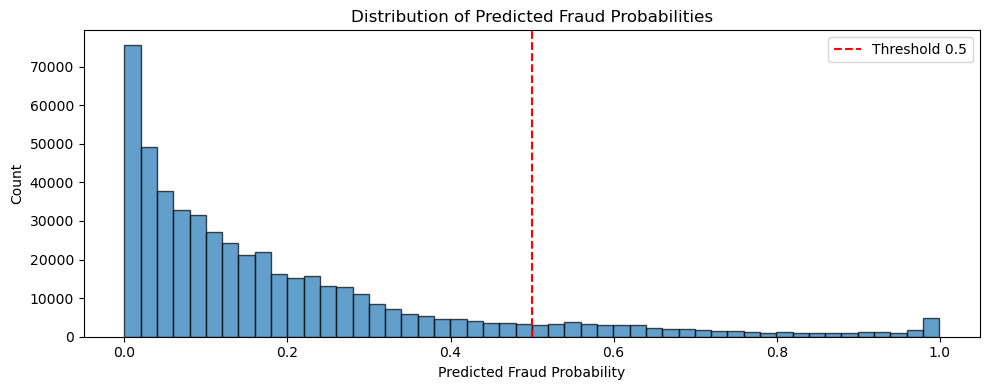


Predicted as Fraud (>0.5): 51093 (10.08%)


In [16]:
# Distribution of predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Fraud Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Fraud Probabilities')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.legend()
plt.tight_layout()
plt.show()

# Count predictions above threshold
print(f"\nPredicted as Fraud (>0.5): {(predictions > 0.5).sum()} ({(predictions > 0.5).mean()*100:.2f}%)")